Below is code with a link to a happy or sad dataset which contains 80 images, 40 happy and 40 sad. 
Create a convolutional neural network that trains to 100% accuracy on these images,  which cancels training upon hitting training accuracy of >.999

Hint -- it will work best with 3 convolutional layers.

In [4]:
import tensorflow as tf
import os
import zipfile

DESIRED_ACCURACY = 0.999

# Downloading dataset.
!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip" \
    -O "/tmp/happy-or-sad.zip"

# Unzipping dataset.
zip_ref = zipfile.ZipFile("/tmp/happy-or-sad.zip", 'r')
zip_ref.extractall("/tmp/h-or-s")
zip_ref.close()

# Creating a callback to stop training after reaching DESIRED_ACCURACY.
class myCallback(tf.keras.callbacks.Callback):
  
  def on_epoch_end(self, epoch, logs={}):
    if logs.get("acc") > DESIRED_ACCURACY:
      print("\nReached 99.9% accuracy, so cancelling training!")
      self.model.stop_training = True

callbacks = [myCallback()]

--2019-04-28 17:51:04--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘/tmp/happy-or-sad.zip’

/tmp/happy-or-sad.z 100%[===================>]   2.55M  --.-KB/s    in 0.02s   

2019-04-28 17:51:05 (135 MB/s) - ‘/tmp/happy-or-sad.zip’ saved [2670333/2670333]



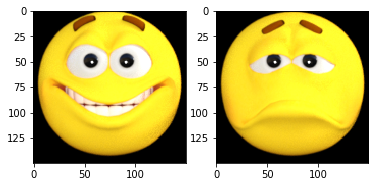

In [12]:
# Showing one of the images of each class so that I can take a look at the dataset
# I am dealing with (each time this cell is run, you'll get two different images
# from the dataset)

root_dir = "/tmp/h-or-s/"

# Getting images.
happy_images = os.listdir(root_dir + "happy")
sad_images = os.listdir(root_dir + "sad")

import random

from tensorflow.keras.preprocessing import image
rand_int1 = random.randint(0, len(happy_images) - 1)
rand_int2 = random.randint(0, len(sad_images) - 1)

happy_img = np.array(image.load_img(root_dir + "happy/{}".format(happy_images[rand_int1])))
sad_img = np.array(image.load_img(root_dir + "sad/{}".format(sad_images[rand_int2])))

imgs = [happy_img, sad_img]

# Plotting images.
import matplotlib.pyplot as plt
num_rows, num_cols = 1, 2
for i, img in enumerate(imgs):
  sb = plt.subplot(num_rows, num_cols, i+1)
  plt.imshow(img)

In [8]:
# Defining our model's architecture.
model = tf.keras.models.Sequential([
    
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 is happy and 1 is sad.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling model.
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["acc"])

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# Creating the training data image generator.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_data_generator = ImageDataGenerator(rescale=1/255)
training_data_generator = training_data_generator.flow_from_directory(
                              "/tmp/h-or-s/",
                              target_size=(150, 150),
                              batch_size=10,
                              class_mode="binary"
)

# Expected output: 'Found 80 images belonging to 2 classes'

Found 80 images belonging to 2 classes.


In [10]:
# Training model with 'fit_generator.'
model.fit_generator(
    training_data_generator,
    steps_per_epoch=8,
    epochs=15,
    verbose=1,
    callbacks=callbacks
)  
# Expected output: "Reached 99.9% accuracy so cancelling training!"

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
8/8 [==============================] - 3s 383ms/step - loss: 0.9243 - acc: 0.4750
Epoch 2/15
8/8 [==============================] - 3s 334ms/step - loss: 0.5411 - acc: 0.8375
Epoch 3/15
8/8 [==============================] - 3s 329ms/step - loss: 0.3234 - acc: 0.8625
Epoch 4/15
8/8 [==============================] - 3s 340ms/step - loss: 0.2570 - acc: 0.8625
Epoch 5/15
8/8 [==============================] - 3s 327ms/step - loss: 0.2041 - acc: 0.9250
Epoch 6/15
8/8 [==============================] - 3s 326ms/step - loss: 0.1270 - acc: 0.9625
Epoch 7/15
8/8 [==============================] - 3s 324ms/step - loss: 0.1065 - acc: 0.9500
Epoch 8/15
8/8 [==============================] - 3s 329ms/step - loss: 0.0651 - acc: 0.9750
Epoch 9/15
7/8 [=========================>....] - ETA: 0s - loss: 0.0454 - acc: 1.0000
Reached 99.9% accuracy, so cancelling training!
8/8 [==============================] - 3s 325ms/step - loss: 0.0416 - acc

In [18]:
# Testing classifier
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

# Getting image.
uploaded = files.upload()
for file_name in uploaded.keys():
  
  path = "/content/" + file_name
  img = image.load_img(path, target_size=(150, 150))
  img = np.array(img)
  imgs = np.expand_dims(img, axis=0)

  # Making prediction.
  predictions = model.predict(imgs)

  if predictions[0] > 0.5:
    print("This is a sad picture. Prediction: {}".format(predictions[0]))
  else:
    print("This is a happy picture. Prediction: {}".format(predictions[0]))

Saving Screen Shot 2019-04-28 at 2.00.57 PM.png to Screen Shot 2019-04-28 at 2.00.57 PM (1).png
This is a happy picture. Prediction: [0.]
